### Linear Regression
Predicting the demand for sharing bikes company to increase the revenue of the company:

1. Exploratory Data Analysis (EDA)
2. Correlation, linearity assumptions and multicollinearity checks
3. Feature selection
4. Train/ test/ eval split
5. Model Building 
6. Model Evaluation 
7. Predictions
8. Interpretation - Business Translation

##### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Hypothesis testing packages
from scipy.stats import f_oneway

### Modelling packages
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.metrics import r2_score

### For displaying the tables
from IPython.display import display


In [56]:
data=pd.read_csv('day.csv')
display(data.head(5))
display(data.info())
data.shape

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


None

(730, 16)

In [3]:
data['dteday']=pd.to_datetime(data['dteday'])

The **target variable** here should be **cnt** which is the sum of casual and registered members of the company.

### 1. Exploratory Data Analysis

* Categorical data visulaization to check the relationship of predictors with target varaible **"cnt"**
* Detecting outliers in the data
* Checking for multicollinearity 
* Linearity of output and input variables assumption - Check

,yr,mnth,casual,registered,cnt,casual_prop,registered_prop
0,0,1,3073,35116,38189,0.080468,0.919532
1,0,2,6242,41973,48215,0.129462,0.870538
2,0,3,12826,51219,64045,0.200265,0.799735
3,0,4,22346,72524,94870,0.235543,0.764457
4,0,5,31050,104771,135821,0.228610,0.771390


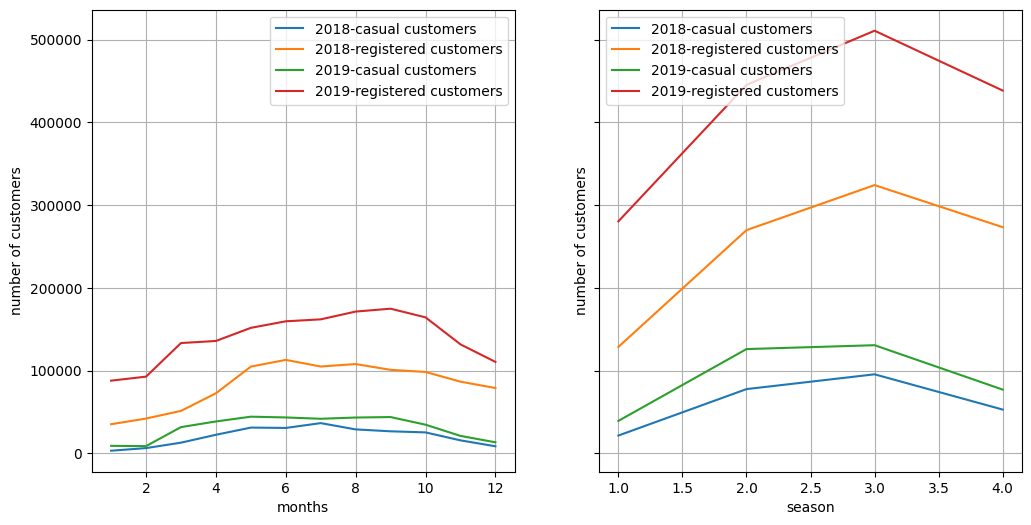

In [4]:
### Categorical varaibles and target varaible
fig, ax= plt.subplots(1,2,figsize=(12,6), sharey=True)

yr_mnth_db=data.groupby(['yr','mnth']).agg({'casual':'sum','registered':'sum','cnt':'sum'}).reset_index()
yr_mnth_db['casual_prop']=yr_mnth_db['casual']/yr_mnth_db['cnt']
yr_mnth_db['registered_prop']=yr_mnth_db['registered']/yr_mnth_db['cnt']
display(yr_mnth_db.head())

### Plotting the graphs
for i,j in zip(yr_mnth_db.yr.unique(),('2018','2019')):
    db=yr_mnth_db[yr_mnth_db['yr']==i]
    ax[0].plot(db.mnth,db.casual,label=f'{j}-casual customers')
    ax[0].plot(db.mnth,db.registered,label=f'{j}-registered customers')
    ax[0].set_xlabel('months')
    ax[0].set_ylabel('number of customers')
    ax[0].legend()
ax[0].grid()
db2=data.groupby(['season','yr']).agg({'casual':'sum','registered':'sum','cnt':'sum'}).reset_index()
for i,j in zip(yr_mnth_db.yr.unique(),('2018','2019')):
    db=db2[db2['yr']==i]
    ax[1].plot(db.season,db.casual,label=f'{j}-casual customers')
    ax[1].plot(db.season,db.registered,label=f'{j}-registered customers')
    ax[1].set_xlabel('season')
    ax[1].set_ylabel('number of customers')
    ax[1].legend()
ax[1].grid()

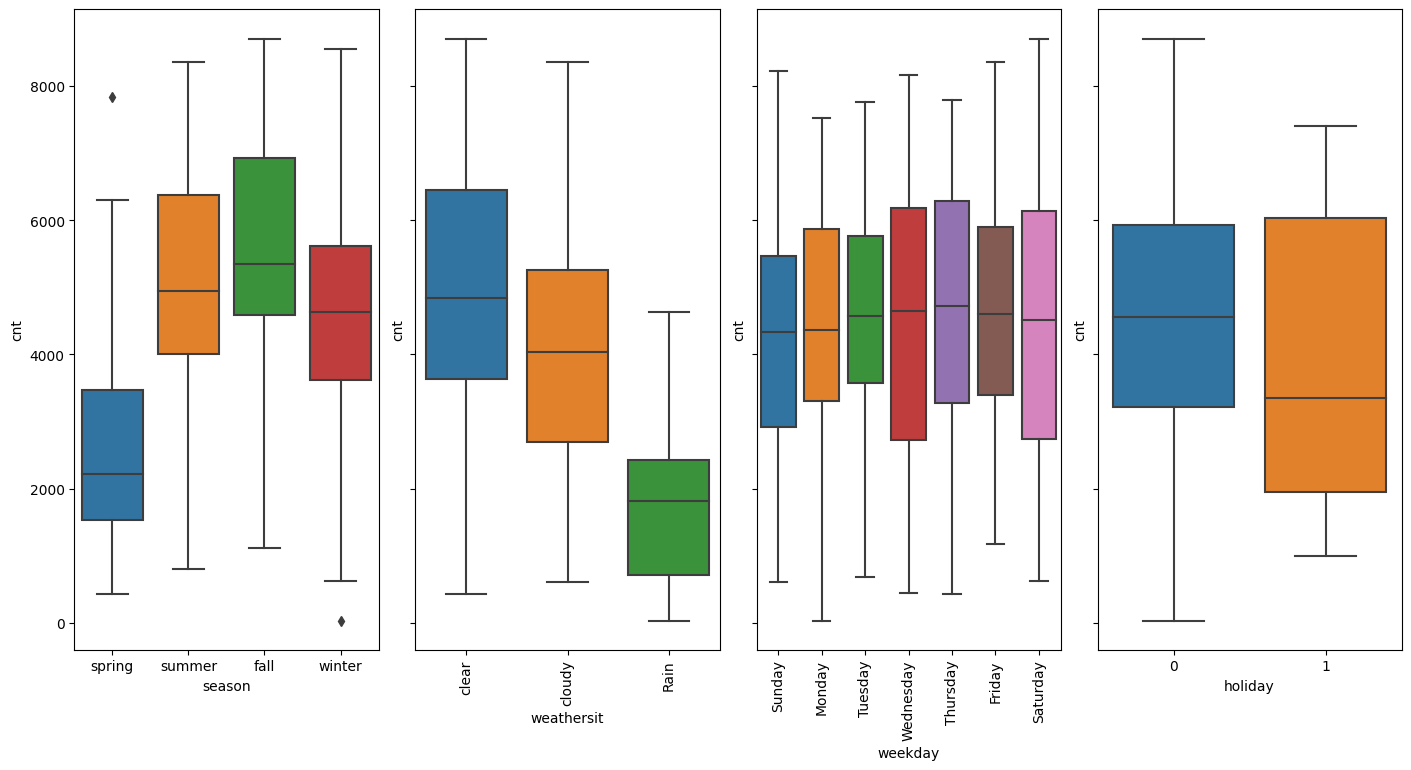

In [5]:
fig, ax= plt.subplots(1,4,figsize=(14,7),sharey=True)
fig.tight_layout()
sns.boxplot(data, x='season',y='cnt',ax=ax[0])
sns.boxplot(data, x='weathersit',y='cnt',ax=ax[1])
sns.boxplot(data, x='weekday',y='cnt',ax=ax[2])
sns.boxplot(data, x='holiday',y='cnt',ax=ax[3])
ax[0].set_xticks(range(data.season.nunique()),('spring','summer','fall','winter'))
ax[1].set_xticks(range(data.weathersit.nunique()),("clear","cloudy","Rain"),rotation=90)
ax[2].set_xticks(range(data.weekday.nunique()),("Sunday","Monday","Tuesday", "Wednesday", "Thursday","Friday","Saturday"),rotation=90)

plt.show()

#### Hypothesis testing

$H_0$: The subgroups of categorical variable has no significant relationship with the target variable 

$H_1$: The subgroups of categorical variable has significant relationship with the target variable 

With the level of significance ($\alpha$): 5%

In [6]:
### Let's test the significance of groups in response to the target variable
for i in ('season','weathersit','weekday','holiday'):
    print(f'{i}- One-way ANOVA test')
    groups=[data['cnt'][data[f'{i}']==j] for j in data[i].unique()]
    # print(groups)
    f_stats, p_value = f_oneway(*groups)
    if p_value<0.05:
        print(f'p value: {p_value:.4f} is much lesser than 0.05. Hence there is a significant difference between the sub-groups of {i} and the target variable cnt')
    else:
        print(f'p value: {p_value:.4f} is greater than 0.05. Hence there is no significant difference between the sub-groups of {i} and the target variable cnt or we fail to reject the null hypothesis')  

season- One-way ANOVA test
p value: 0.0000 is much lesser than 0.05. Hence there is a significant difference between the sub-groups of season and the target variable cnt
weathersit- One-way ANOVA test
p value: 0.0000 is much lesser than 0.05. Hence there is a significant difference between the sub-groups of weathersit and the target variable cnt
weekday- One-way ANOVA test
p value: 0.5722 is greater than 0.05. Hence there is no significant difference between the sub-groups of weekday and the target variable cnt or we fail to reject the null hypothesis
holiday- One-way ANOVA test
p value: 0.0633 is greater than 0.05. Hence there is no significant difference between the sub-groups of holiday and the target variable cnt or we fail to reject the null hypothesis


<AxesSubplot:>

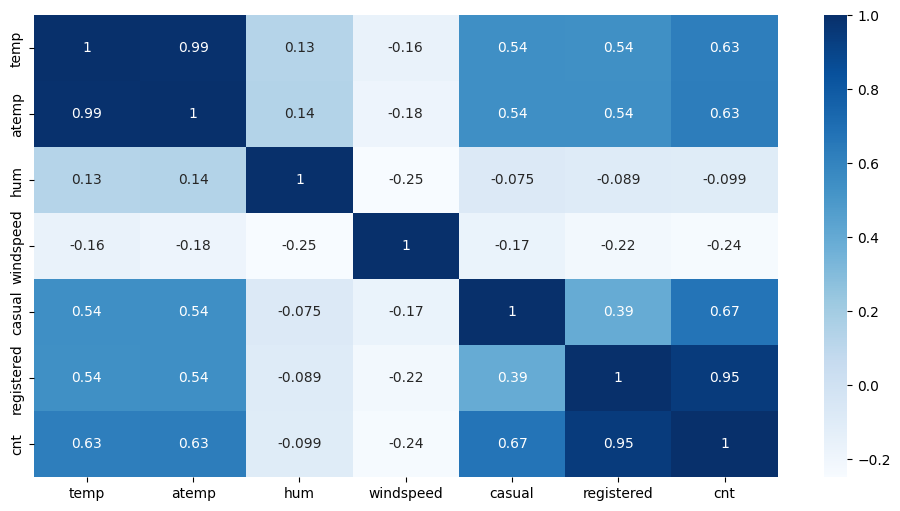

In [7]:
#### Numerical Variables - Correlation matrix 
plt.subplots(figsize=(12,6))
sns.heatmap(data[['temp', 'atemp', 'hum', 'windspeed', 'casual','registered', 'cnt']].corr(),cmap='Blues',annot=True)

Having said that, **cnt** is the target variable. Correlation of cnt with the following variables and it's relevance to be added 
* temp has positive correlation of 63% - Adding this variable as a feature would explain the variability of target variable
* atemp and temp seems to have higly correlated - Might fail the no-multicollinearity assumption of LR - recommended not to add
* windspeed and humidity are negatively correlated - Although the relationship is weaker, there is no harm in adding it as features
* **Casual and registered are highly correlated with 67% and 95%**. However, this is deterministic as the **cnt** is the sum of those two variables. Ideally, we should not consider these two variables as feature input due to **data leakage issues (using parts of output as input is malicious for the model accuracy)**

Let's confirm the same with variance inflation factor (VIF)

In [8]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [9]:
# the independent variables set
feat=['season','yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'temp','atemp', 'hum', 'windspeed']
for i in range(100):
    X = data[feat]
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = feat

    # calculating VIF for each feature
    vif_data["VIF"] = [VIF(X.values, i) for i in range(len(feat))]
    ### VIF threshold is 10 
    if (vif_data["VIF"].max()>10):
        display(vif_data)
        rm_val=feat.pop(np.argmax(vif_data["VIF"]))
        print(f'Iter: {i+1}; Removed feature:{rm_val} ({vif_data["VIF"].max():.2f}) & Next_list: {feat}\n')
    else:
        print(f'Features set with no multicollinearity: {feat}')
        display(vif_data)
        break  

,feature,VIF
0,season,21.247217
1,yr,1.950692
2,mnth,15.228307
3,holiday,1.098748
4,weekday,3.086901
5,workingday,3.261574
6,temp,491.765997
7,atemp,553.963720
8,hum,13.633906
9,windspeed,5.087744


Iter: 1; Removed feature:atemp (553.96) & Next_list: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'hum', 'windspeed']



,feature,VIF
0,season,21.113623
1,yr,1.942951
2,mnth,15.219827
3,holiday,1.098737
4,weekday,3.085652
5,workingday,3.253930
6,temp,8.928794
7,hum,12.118539
8,windspeed,5.087612


Iter: 2; Removed feature:season (21.11) & Next_list: ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'hum', 'windspeed']



,feature,VIF
0,yr,1.942648
1,mnth,5.019439
2,holiday,1.098061
3,weekday,3.085457
4,workingday,3.250588
5,temp,8.028479
6,hum,11.952514
7,windspeed,5.087601


Iter: 3; Removed feature:hum (11.95) & Next_list: ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'windspeed']

Features set with no multicollinearity: ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'windspeed']


,feature,VIF
0,yr,1.940193
1,mnth,4.286598
2,holiday,1.090465
3,weekday,3.004494
4,workingday,3.096789
5,temp,6.568647
6,windspeed,4.460436


Using VIF, variables with high VIF (>10) are removed and the final set of features are ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'windspeed']
year, month, holiday, weekday and workingday, temperature and windspeed are the major drivers of demand in 


#### Feature selection

1. Rescaling or standardizing the features set
2. Train the model
3. Check for Bias and Variance of the model fitted
4. Predictions and evaluation on test data & Interpretations


In [51]:
### Splitting for train and test variables
features_to_std =['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp','atemp' ,'hum', 'windspeed','cnt']

df_train,df_test=train_test_split(data[features_to_std], train_size=0.7,random_state=100)
display(df_train.head())
display(df_test.head())
### Rescaling-Standardizing 
Scaler= MinMaxScaler()

df_train[features_to_std]=Scaler.fit_transform(df_train)
print('Normalized X train:')
display(df_train.head())
display(df_train.describe())
df_test[features_to_std]=Scaler.transform(df_test)
print('\nNormalized X test:')
display(df_test.describe())


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
576,3,1,7,0,2,1,1,29.246653,33.1448,70.4167,11.083475,7216
426,1,1,3,0,6,0,2,16.980847,20.6746,62.1250,10.792293,4066
728,1,1,12,0,0,0,1,10.489153,11.5850,48.3333,23.500518,1796
482,2,1,4,0,6,0,2,15.443347,18.8752,48.9583,8.708325,4220
111,2,0,4,0,5,1,2,13.803347,16.0977,72.9583,14.707907,1683


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
184,3,0,7,1,1,0,2,29.793347,33.27085,63.7917,5.459106,6043
535,2,1,6,0,3,1,1,32.082500,36.04875,59.2083,7.625404,6211
299,4,0,10,0,4,1,2,19.270000,22.85230,81.2917,13.250121,2659
221,3,0,8,0,3,1,1,31.433347,34.24915,42.4167,13.417286,4780
152,2,0,6,0,4,1,1,29.315000,32.19710,30.5000,19.583229,4968


Normalized X train:


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
576,0.666667,1.0,0.545455,0.0,0.333333,1.0,0.0,0.815169,0.766351,0.725633,0.264686,0.827658
426,0.000000,1.0,0.181818,0.0,1.000000,0.0,0.5,0.442393,0.438975,0.640189,0.255342,0.465255
728,0.000000,1.0,1.000000,0.0,0.000000,0.0,0.0,0.245101,0.200348,0.498067,0.663106,0.204096
482,0.333333,1.0,0.272727,0.0,1.000000,0.0,0.5,0.395666,0.391735,0.504508,0.188475,0.482973
111,0.333333,0.0,0.272727,0.0,0.833333,1.0,0.5,0.345824,0.318819,0.751824,0.380981,0.191095


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.504575,0.507843,0.503743,0.025490,0.498366,0.676471,0.201961,0.537440,0.513156,0.650480,0.320883,0.513499
std,0.370078,0.500429,0.315038,0.157763,0.336182,0.468282,0.273944,0.225858,0.212410,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.181818,0.000000,0.166667,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420
50%,0.666667,1.000000,0.545455,0.000000,0.500000,1.000000,0.000000,0.542596,0.529718,0.653714,0.296763,0.518638
75%,0.666667,1.000000,0.818182,0.000000,0.833333,1.000000,0.500000,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Normalized X test:


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.487879,0.481818,0.499174,0.036364,0.502273,0.700000,0.186364,0.558718,0.532847,0.638221,0.313293,0.522154
std,0.370602,0.500809,0.311120,0.187620,0.330843,0.459303,0.269102,0.233187,0.217401,0.148694,0.159584,0.219163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205
25%,0.000000,0.000000,0.272727,0.000000,0.166667,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595
50%,0.333333,0.000000,0.454545,0.000000,0.500000,1.000000,0.000000,0.558172,0.544652,0.625590,0.300126,0.524678
75%,0.666667,1.000000,0.727273,0.000000,0.833333,1.000000,0.500000,0.755981,0.713308,0.743798,0.402718,0.677750
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300


In [79]:
features =['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp','atemp', 'hum', 'windspeed']
model_metrics=pd.DataFrame()
feats=[]
for i in range(10):
    Y_train=df_train['cnt']
    X_train=df_train[features]
    
    Y_test=df_test['cnt']
    X_test=df_test[features]
    
    c_sm=sm.add_constant(X_train)
    lm=sm.OLS(Y_train,c_sm)
    model=lm.fit()
    
    c_sm_test=sm.add_constant(X_test)
    y_pred=model.predict(c_sm_test)
    rscore=r2_score(Y_test,y_pred)
     
    tb=pd.DataFrame({'features':list(model.pvalues.index),'p-value':model.pvalues.values}).assign(Model=f"Model_{i+1}",rsquared=model.rsquared,adj_rsquared=model.rsquared_adj,pred_r2score=rscore)
    model_metrics=pd.concat([model_metrics,tb])
    
    if (model.pvalues.max())>0.05:
        to_remove_feature=np.argmax(model.pvalues)-1
        print(model.pvalues.index[np.argmax(model.pvalues)])
        features.pop(to_remove_feature)
        print(f'Next iteration features set:{features}')
    else:
        print(f'Final Model {i+1} with R-squared and Adjusted R-squared: {model.rsquared} & {model.rsquared_adj} respectively ')
        break

mnth
Next iteration features set:['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
temp
Next iteration features set:['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed']
Final Model 3 with R-squared and Adjusted R-squared: 0.8028985743695235 & 0.7993507487081749 respectively 


In [80]:
model_metrics
# np.argmax(model.pvalues)


,features,p-value,Model,rsquared,adj_rsquared,pred_r2score
0,const,2.392439e-08,Model_1,0.803956,0.799626,0.788012
1,season,6.693519e-09,Model_1,0.803956,0.799626,0.788012
2,yr,5.819273e-95,Model_1,0.803956,0.799626,0.788012
3,mnth,5.692695e-01,Model_1,0.803956,0.799626,0.788012
4,holiday,1.964073e-02,Model_1,0.803956,0.799626,0.788012
5,weekday,4.784269e-04,Model_1,0.803956,0.799626,0.788012
6,workingday,4.891513e-02,Model_1,0.803956,0.799626,0.788012
7,weathersit,2.401117e-13,Model_1,0.803956,0.799626,0.788012
8,temp,1.265210e-01,Model_1,0.803956,0.799626,0.788012
9,atemp,5.948408e-02,Model_1,0.803956,0.799626,0.788012


In [90]:
vif_data = pd.DataFrame()
vif_data["feature"] = features
X=pd.concat([df_train[features],df_test[features]])
# calculating VIF for each feature
vif_data["VIF"] = [VIF(X.values, i) for i in range(len(features))]

In [91]:
vif_data

,feature,VIF
0,season,3.365818
1,yr,1.933215
2,holiday,1.098851
3,weekday,3.049649
4,workingday,3.232700
5,weathersit,2.197142
6,atemp,8.119699
7,hum,14.636242
8,windspeed,3.732843


In [ ]:
# r2_score(Y_test, y_pred)
# y_pred=model.predict(X_test)
y_train_pred=model.predict(c_sm)

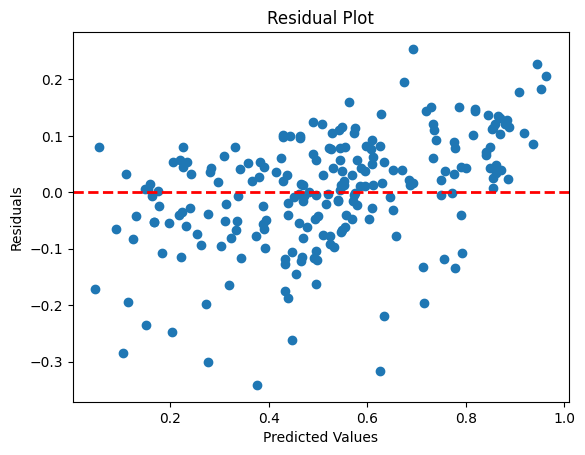

In [86]:
# plt.scatter(y_pred,Y_train-y_pred)
plt.scatter(Y_test,Y_test-y_pred)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()
# plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], color='red', linestyle='--', linewidth=2)  # Diagonal line


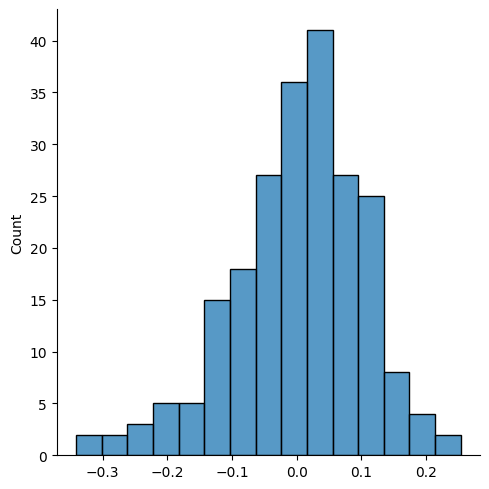

In [89]:
sns.displot(Y_test-y_pred)

In [ ]:
x_test_sm=sm.add_constant(X_test_std)
y_pred=model.predict(x_test_sm)
# x_test_sm

In [ ]:
r2_score(Y_test,y_pred)

In [ ]:
plt.hist(data['cnt'],bins=100)
plt.show()

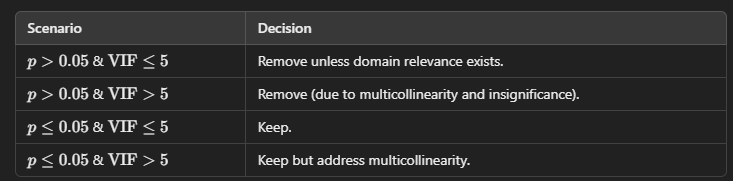